## COVID 19: Movilidad y mortalidad

Nos piden analizar los siguientes datos sobre COVID-19 para un reporte de prensa. Queremos dar cuenta de la situación en los distintos ¿Cómo impactaron las medidas que tomó cada país en la movilidad de la gente? Y a su vez ¿Cómo impactó esto en la salud de la población, particularmente en la cantidad de fallecimientos reportados?

Para responder a estas preguntas vamos a unir dos fuentes de datos: la primera, el reporte de fallecimientos diarios en cada país que consolida la Universidad John Hopkins https://coronavirus.jhu.edu/data y el <a href='https://www.google.com/covid19/mobility/'> reporte de movilidad de Google </a> que geolocaliza la ubicación de cada usuario e infiere a partir de datos históricos y otros, dónde se encuentran las personas: en su casa, trabajo, farmacias y supermercados, parques, etc. A partir de estos datos, creó un índice para comparar la cantidad de tiempo que la gente pasa en cada lugar con respecto a un benchmark previo a la pandemia. El índice que mejor resume el nivel de aislmiento es la cantidad de tiempo pasada en el hogar: cuanto más alto, mayor aislamiento.

Para ganar agilidad, ya subimos los dos data sets a nuestros servidores para que puedan consultarlos de ahí:

In [139]:
#Importamos algunas librerías
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go


### 1. Datos de movilidad

In [2]:
df_movilidad = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/mobility.csv',low_memory=False)

In [3]:
df_mortalidad = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/time_series_covid19_deaths_global.csv')

In [4]:
df_movilidad.sample(5)

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
625914,US,United States,Texas,Navarro County,NaN,48349.0,2020-04-11,-49.0,27.0,-36.0,-58.0,-34.0,NaN
68211,ES,Spain,Valencian Community,NaN,ES-VC,NaN,2020-03-04,1.0,3.0,18.0,6.0,3.0,0.0
257918,TR,Turkey,Batman,NaN,TR-72,NaN,2020-05-17,-47.0,-4.0,-18.0,NaN,-17.0,13.0
678990,US,United States,Wisconsin,Manitowoc County,NaN,55071.0,2020-04-01,-40.0,-15.0,NaN,NaN,-34.0,15.0
645305,US,United States,Virginia,Charlotte County,NaN,51037.0,2020-05-15,NaN,NaN,NaN,NaN,-28.0,NaN


In [10]:
df_movilidad.shape

(704141, 13)

Noten que los datos en el Data Frame están mezclados: hay a nivel ciudad, provincia y país.


Cuando la sub_region_2 está nula, los datos reflejan el total de la sub_region_1. Cuando las subregiones 1 y 2 están vacías, los datos reflejan a todo el país. Este es el dato que nos interesa así que el primer paso es filtrar el dataframe <b> dejando únicamente los valores donde sub_region_1 y sub_region_2 son null </b>. ¿Cuántas filas tiene el DataFrame antes y después de filtrarlo?


In [9]:
df_movilidad_pais = df_movilidad[(df_movilidad['sub_region_1'].isnull() & 
                                  df_movilidad['sub_region_2'].isnull())]
df_movilidad_pais                             

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
702792,ZW,Zimbabwe,NaN,NaN,NaN,NaN,2020-07-15,-9.0,-1.0,-4.0,-28.0,-12.0,23.0
702793,ZW,Zimbabwe,NaN,NaN,NaN,NaN,2020-07-16,-8.0,0.0,-7.0,-27.0,-12.0,23.0
702794,ZW,Zimbabwe,NaN,NaN,NaN,NaN,2020-07-17,-8.0,5.0,-6.0,-24.0,-8.0,22.0
702795,ZW,Zimbabwe,NaN,NaN,NaN,NaN,2020-07-18,-7.0,8.0,-3.0,-16.0,6.0,17.0


In [123]:
df_mov2 = df_movilidad[(df_movilidad['sub_region_1'].isnull() & 
                        df_movilidad['sub_region_2'].isnull())].copy()
df_mov2 = df_mov2[['country_region','date','residential_percent_change_from_baseline']].copy()
df_mov2['date'] = pd.to_datetime(df_mov2['date'], format="%Y-%m-%d" )
df_mov2 = df_mov2.dropna()
df_mov2

,country_region,date,residential_percent_change_from_baseline
0,United Arab Emirates,2020-02-15,1.0
1,United Arab Emirates,2020-02-16,1.0
2,United Arab Emirates,2020-02-17,1.0
3,United Arab Emirates,2020-02-18,1.0
4,United Arab Emirates,2020-02-19,1.0
...,...,...,...
702792,Zimbabwe,2020-07-15,23.0
702793,Zimbabwe,2020-07-16,23.0
702794,Zimbabwe,2020-07-17,22.0
702795,Zimbabwe,2020-07-18,17.0


In [14]:
df_movilidad_pais.shape
# El DataFrame se redujo de 704141 a 20925 filas

(20925, 13)

In [13]:
len(df_movilidad['country_region'].unique())
# 135 países

135

In [12]:
len(df_movilidad_pais['country_region'].unique())

135

Como dijimos más arriba, el dato más importante para medir la reducción de la movilidad es 'residential_percent_change_from_baseline'. Este valor refleja cuánto más tiempo al día pasa la gente en su propia casa, lejos de cualquier posibilidad de contagio. 

¿Cuáles fueron <b> los 3 países </b> que en promedio más redujeron la movilidad entre el 1 de marzo y el 1 de abril? ¿Y entre el 1 de abril y el 1 de mayo? 

Hint: No dejen de convertir la serie que contiene una fecha con la función pd.to_datetime().

### 2. Ranking de cuarentenas

In [20]:
# Vamos a quedarnos únicamente con las 3 columnas que vamos a usar
df_mov = df_movilidad[['country_region','date','residential_percent_change_from_baseline']].copy()

In [21]:
#Eliminamos las que tienen algún dato faltante
df_mov = df_mov.dropna()

In [24]:
df_mov['date'] = pd.to_datetime(df_mov['date'], format="%Y-%m-%d" )

In [50]:
# Sumo ambas cuarentenas en 2 columnas distintas
df_mov_q1q2 = df_mov[(df_mov['date']>='2020-03-01') & (df_mov['date']<'2020-04-01')].\
      groupby('country_region').agg({'residential_percent_change_from_baseline':'mean'})
df_mov_q1q2['q2'] = df_mov[(df_mov['date']>='2020-04-01') & (df_mov['date']<'2020-05-01')].\
      groupby('country_region').agg({'residential_percent_change_from_baseline':'mean'})
df_mov_q1q2

,residential_percent_change_from_baseline,q2
country_region,,
Afghanistan,2.935484,13.300000
Angola,6.741935,26.383333
Antigua and Barbuda,7.227273,26.400000
Argentina,12.225806,23.738667
Aruba,12.517241,29.850000
...,...,...
Venezuela,10.451613,20.166667
Vietnam,6.778926,13.979935
Yemen,2.258065,4.533333


In [51]:
df_mov_q1q2.columns=['q1', 'q2']
df_mov_q1q2.reset_index()

,country_region,q1,q2
0,Afghanistan,2.935484,13.300000
1,Angola,6.741935,26.383333
2,Antigua and Barbuda,7.227273,26.400000
3,Argentina,12.225806,23.738667
4,Aruba,12.517241,29.850000
...,...,...,...
127,Venezuela,10.451613,20.166667
128,Vietnam,6.778926,13.979935
129,Yemen,2.258065,4.533333
130,Zambia,4.096774,12.833333


In [54]:
df_mov_q1q2['dif_aislam_q1_q2']=df_mov_q1q2['q2']-df_mov_q1q2['q1']
df_mov_q1q2.sort_values('dif_aislam_q1_q2', ascending=False).head(3)
# Los 3 países que redujeron su movilidad porcentual, o bien que aumentaron su ailamiento son: Zimbabwe, Botswana, Uganda

,q1,q2,dif_aislam_q1_q2
country_region,,,
Zimbabwe,6.493827,40.907407,34.413580
Botswana,3.354839,36.066667,32.711828
Uganda,3.865385,31.901639,28.036255


### 3. Ahora Argentina

Ahora filtren los datos de movilidad en df_movilidad para quedarnos sólo con Argentina y almacenarlo en un nuevo DataFrame df_ar. 

In [56]:
df_ar=df_movilidad[df_movilidad['country_region']=='Argentina']
df_ar

,country_region_code,country_region,sub_region_1,sub_region_2,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
2765,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
2766,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
2767,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
2768,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
2769,AR,Argentina,NaN,NaN,NaN,NaN,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6660,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-07-15,-21.0,14.0,-39.0,-48.0,-2.0,7.0
6661,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-07-16,-22.0,9.0,-39.0,-49.0,-2.0,7.0
6662,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-07-17,-20.0,19.0,-39.0,-52.0,0.0,7.0
6663,AR,Argentina,Tucumán,NaN,AR-T,NaN,2020-07-18,-22.0,18.0,-46.0,-56.0,6.0,6.0


¿Qué rango de fechas cubren los datos de movilidad?

In [63]:
# df_ar['date'].unique()
# len(df_ar['date'].unique()) #156 días
# df_ar['date'].min() #2020-02-15
# df_ar['date'].max() #2020-07-19
pd.to_datetime(df_ar['date'].max())-pd.to_datetime(df_ar['date'].min()) #Timedelta('155 days 00:00:00')
# El rango es de 2020-02-15 al 2020-07-19, continuos, sin días faltantes

Timedelta('155 days 00:00:00')

Queremos ver cómo evolucionó en Argentina cada uno de los tipos de movilidad. Grafiquen en un mismo lugar la evolución de las series 'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline',
'residential_percent_change_from_baseline' y 'parks_percent_change_from_baseline' en función de la fecha.

In [73]:
df_ar2 = df_ar[['date','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline', 'parks_percent_change_from_baseline','residential_percent_change_from_baseline']].copy()
df_ar2['date'] = pd.to_datetime(df_ar2['date'], format="%Y-%m-%d" )
df_ar2.set_index('date', inplace=True)

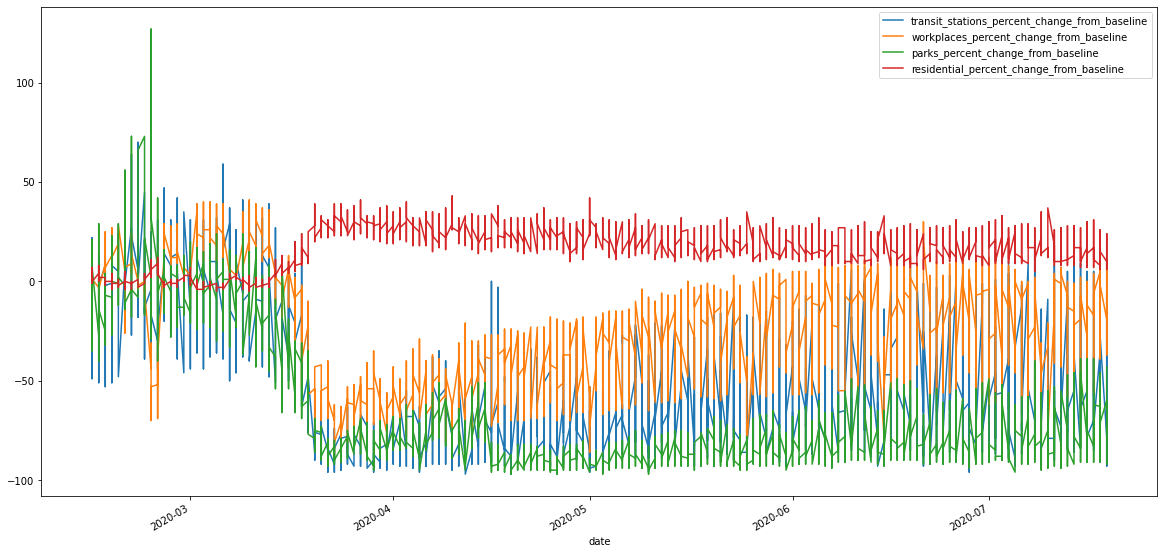

In [78]:
df_ar2.plot(kind='line',figsize=(20,10))

### 4. Datos de Mortalidad

Ahora analicemos datos de mortalidad. 

In [79]:
df_mortalidad.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,451,471,478,491,504,546,548,569,581,598,618,639,675,683,703,721,733,746,774,807,819,826,864,898,920,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,36,36,36,37,38,39,42,43,44,44,45,47,49,51,53,55,58,62,65,69,72,74,76,79,81,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,760,767,777,788,799,811,825,837,845,852,861,869,878,885,892,897,905,912,920,928,937,946,952,959,968,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,51,51,51,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,7,8,8,9,9,10,10,10,10,10,10,11,11,13,15,17,18,19,19,19,21,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33


In [80]:
df_mortalidad.shape

(266, 187)

Igual que en el DataFrame anterior, cuando el campo 'Province/State' está vacío, los datos se refieren al agregado nacional. Filtren las filas que tengan este campo vacío y controlen la cantidad antes y después.

In [83]:
df_mortalidad_pais = df_mortalidad[(df_mortalidad['Province/State'].isnull())]
df_mortalidad_pais.shape


(185, 187)

In [ ]:
# El DataFrame se redujo de 266 a 185 filas

In [84]:
df_mortalidad_pais.sample(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20
253,NaN,Burundi,-3.373100,29.918900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
47,NaN,Chad,15.454200,18.732200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,72,73,73,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,75,75,75,75,75,75,75,75,75,75,75
234,NaN,Mozambique,-18.665695,35.529562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,3,3,4,4,4,4,4,5,5,5,5,5,5,5,5,6,6,6,6,6,7,8,8,8,8,9,9,9,9,9,9,9,9,9,10,10,11,11,11
157,NaN,Mauritius,-20.348404,57.552152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
186,NaN,Romania,45.943200,24.966800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1394,1410,1427,1437,1451,1473,1484,1500,1512,1523,1539,1555,1565,1579,1589,1612,1634,1651,1667,1687,1708,1731,1750,1768,1799,1817,1834,1847,1871,1884,1901,1931,1952,1971,1988,2009,2026,2038,2074,2101


Parece que tenemos un nuevo candidato para el paper de Witham sobre Tidy Data!! Intenten crear un dataframe como el de Google, que contenga la mortalidad por país y por fecha.

Hint: como siempre la función clave para reducir columnas a variables es pd.melt().

Intenten crear un nuevo DataFrame a partir del anterior, df_mort y asignen estos nombres de columnas:

df_mort.columns = ['Province','Country','Lat','Long','Date','Mortalidad']

In [103]:
df_mort = pd.melt(df_mortalidad_pais,
                  id_vars=['Province/State','Country/Region','Lat','Long'],
                  var_name='date',
                  value_name='casos')
df_mort['date'] = pd.to_datetime(df_mort['date'], format='%m/%d/%y')
df_mort

,Province/State,Country/Region,Lat,Long,date,casos
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
33850,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-22,14
33851,NaN,Yemen,15.552727,48.516388,2020-07-22,458
33852,NaN,Comoros,-11.645500,43.333300,2020-07-22,7
33853,NaN,Tajikistan,38.861000,71.276100,2020-07-22,58


In [104]:
df_mort.columns = ['Province','Country','Lat','Long','Date','Mortalidad']
df_mort

,Province,Country,Lat,Long,Date,Mortalidad
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0
...,...,...,...,...,...,...
33850,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-22,14
33851,NaN,Yemen,15.552727,48.516388,2020-07-22,458
33852,NaN,Comoros,-11.645500,43.333300,2020-07-22,7
33853,NaN,Tajikistan,38.861000,71.276100,2020-07-22,58


¿Cuál es el rango de fechas de los datos de mortalidad?

In [105]:
# df_mort['Date'].unique()
# len(df_mort['Date'].unique()) #183 días
# df_mort['Date'].min() #2020-01-22
# df_mort['Date'].max() #2020-07-22
pd.to_datetime(df_mort['Date'].max())-pd.to_datetime(df_mort['Date'].min()) #Timedelta('182 days 00:00:00')
# El rango es de 2020-01-22 al 2020-07-22, continuos, sin días faltantes

Timedelta('182 days 00:00:00')

## Unir las tablas

Ahora vamos a unir las tablas de movilidad y mortalidad de manera tal que para cada país y cada día tengamos datos tanto de movilidad como de mortalidad. Guarden el resultado en un nuevo DataFrame **df_full**. Es de esperar que algunos registros se pierdan en el merge porque los países no estén escritos exactamente igual, pero en la mayoría de los casos el nombre coincide. 

Hint: Asegurénse de hacer un merge por país y por fecha.

El DataFrame resultante debería tener las siguientes columnas: Index(['Province', 'Country', 'Lat', 'Long', 'Date', 'Mortalidad',
       'country_region', 'date', 'residential_percent_change_from_baseline'],
      dtype='object')

In [129]:
# df_mov2.sample(5)
# Index(['Province', 'Country', 'Lat', 'Long', 'Date', 'Mortalidad', 'country_region', 'date', 'residential_percent_change_from_baseline']
df_full = df_mort.merge(df_mov2, left_on=['Country', 'Date'], right_on=['country_region', 'date'])
df_full

,Province,Country,Lat,Long,Date,Mortalidad,country_region,date,residential_percent_change_from_baseline
0,NaN,Afghanistan,33.939110,67.709953,2020-02-15,0,Afghanistan,2020-02-15,5.0
1,NaN,Angola,-11.202700,17.873900,2020-02-15,0,Angola,2020-02-15,1.0
2,NaN,Antigua and Barbuda,17.060800,-61.796400,2020-02-15,0,Antigua and Barbuda,2020-02-15,3.0
3,NaN,Argentina,-38.416100,-63.616700,2020-02-15,0,Argentina,2020-02-15,0.0
4,NaN,Austria,47.516200,14.550100,2020-02-15,0,Austria,2020-02-15,-2.0
...,...,...,...,...,...,...,...,...,...
18484,NaN,Libya,26.335100,17.228331,2020-07-19,48,Libya,2020-07-19,-1.0
18485,NaN,Mali,17.570692,-3.996166,2020-07-19,121,Mali,2020-07-19,3.0
18486,NaN,Botswana,-22.328500,24.684900,2020-07-19,1,Botswana,2020-07-19,10.0
18487,NaN,Yemen,15.552727,48.516388,2020-07-19,445,Yemen,2020-07-19,4.0


Ahora vamos a filtrar los datos para quedarnos únicamente con 3 países escandinamos: ['Sweden', 'Denmark', 'Finland'] y guardarlos en un nuevo DataFrame **df_escan**.

In [130]:
escandinavos = ['Sweden', 'Denmark', 'Finland']

In [134]:
df_escan = df_full[df_full['Country'].isin(escandinavos)]
df_escan

,Province,Country,Lat,Long,Date,Mortalidad,country_region,date,residential_percent_change_from_baseline
23,NaN,Denmark,56.263900,9.501800,2020-02-15,0,Denmark,2020-02-15,0.0
30,NaN,Finland,61.924110,25.748151,2020-02-15,0,Finland,2020-02-15,0.0
96,NaN,Sweden,60.128161,18.643501,2020-02-15,0,Sweden,2020-02-15,0.0
142,NaN,Denmark,56.263900,9.501800,2020-02-16,0,Denmark,2020-02-16,1.0
149,NaN,Finland,61.924110,25.748151,2020-02-16,0,Finland,2020-02-16,1.0
...,...,...,...,...,...,...,...,...,...
18281,NaN,Finland,61.924110,25.748151,2020-07-18,328,Finland,2020-07-18,-7.0
18347,NaN,Sweden,60.128161,18.643501,2020-07-18,5619,Sweden,2020-07-18,-3.0
18393,NaN,Denmark,56.263900,9.501800,2020-07-19,611,Denmark,2020-07-19,-3.0
18400,NaN,Finland,61.924110,25.748151,2020-07-19,328,Finland,2020-07-19,-9.0


Comprueben la cantidad de filas que hay en el DataFrame.

In [135]:
df_escan.shape

(468, 9)

Si el DataFrame df_escan está correctamente creado, deberían poder correr el siguiente gráfico ¿Qué es lo que está mostrando? Escriban un párrafo interpretando estos datos. 

In [137]:
def agregarPlotPais(fig,pais):
    color = ['red','green','blue'][escandinavos.index(pais)]
    df_pais = df_escan.query(f'Country=="{pais}"')
    # Add traces
    fig.add_trace(
    go.Scatter(x=df_pais.Date, y=df_pais.residential_percent_change_from_baseline, 
               line=dict(color=color), name=f"movilidad {pais}"),
    secondary_y=False,
)

    fig.add_trace(
        go.Scatter(x=df_pais.Date, y=df_pais.Mortalidad, 
                   line=dict(color=color), name=f"mortalidad {pais}"),
        secondary_y=True,
    )

In [140]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

for pais in ['Sweden', 'Denmark', 'Finland']:
    agregarPlotPais(fig, pais)
    
# Agregamos un título
fig.update_layout(
    title_text="Movilidad y Mortalidad"
)

# Eje X
fig.update_xaxes(title_text="día")

# Ejes Y (primario y secundario)
fig.update_yaxes(title_text="<b>movilidad</b> (cantidad de tiempo en la residencia)", secondary_y=False)
fig.update_yaxes(title_text="<b>mortalidad</b> (cantidad de fallecidos)", secondary_y=True)

fig.show()

In [ ]:
# Los 3 paises escandinavos mantuvieron patrones de movilidad parecidos a lo largo del tiempo.
# Las cuarenternas comenzaron de forma sincronizada en dichos paises.
# A mediados de Marzo 2020, cuando el aislamiento comenzó a hacerse mas duro, solo Finlandia y Dinamarca mantuvieron un bajo nivel de mortalidad, 
# pero el caso de Suecia muestra un llamativo ascenso del dicha tasa, donde habría que ver el motivo por el cual no pudieron hacer frente a ese acelerado porcentaje.
# Quizá debido a la menor capacidad de camas de Atención de Cuidados Intensivos en su infraestructura de salud.